In [1]:
import os
from sys import stdout
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils

import matplotlib
#%matplotlib notebook
#%matplotlib inline
#matplotlib.use('nbagg')
#import mpld3
#mpld3.enable_notebook()

from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict

import numpy as np
from numpy.linalg import norm
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter
import scipy.io

import warnings
warnings.filterwarnings('ignore')

In [2]:
def drPLS(x_input,y_input, **kwargs):
    """
    drPLS: (automatic) Baseline correction method based on doubly reweighted penalized least squares.
    Xu et al., Applied Optics 58(14):3913-3920.
    
    Allows subtracting a baseline under a x y spectrum.
    
    Parameters
    ----------
    x_input : ndarray
        x values.
    
    y_input : ndarray
        y values.
        
    kwargs:  #optional parameters
        niter = kwargs.get('niter',100)
        lam = kwargs.get('lam',1000000)
        eta = kwargs.get('eta',0.5)
        ratio = kwargs.get('ratio',0.001)

    Returns
    -------
    out1 : ndarray
        Contain the corrected signal.
    out2 : ndarray
        Contain the baseline.
    """
    # we get the signals in the bir
    # yafit_unscaled = get_portion_interest(x_input,y_input,bir)

    # signal standard standardization with sklearn
    # this helps for polynomial fitting
    X_scaler = StandardScaler().fit(x_input.reshape(-1, 1))
    Y_scaler = StandardScaler().fit(y_input.reshape(-1, 1))

    # transformation
    x = X_scaler.transform(x_input.reshape(-1, 1))
    y = Y_scaler.transform(y_input.reshape(-1, 1))

    #yafit = np.copy(yafit_unscaled)
    #yafit[:,0] = X_scaler.transform(yafit_unscaled[:,0].reshape(-1, 1))[:,0]
    #yafit[:,1] = Y_scaler.transform(yafit_unscaled[:,1].reshape(-1, 1))[:,0]

    y = y.reshape(len(y_input))    
    
    #according to Applied Optics, 2019, 58, 3913-3920.

    #optional parameters
    niter = kwargs.get('niter',100)
    lam = kwargs.get('lam',1000000)
    eta = kwargs.get('eta',0.5)
    ratio = kwargs.get('ratio',0.001)

    #optional smoothing in the next line, currently commented out
    #y = np.around(savgol_filter(raw_data,19,2,deriv=0,axis=1),decimals=6)

    L = len(y)

    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2),format='csr')
    D = D.dot(D.transpose())
    D_1 = sparse.diags([-1,1],[0,-1],shape=(L,L-1),format='csr')
    D_1 = D_1.dot(D_1.transpose())

    w_0 = np.ones(L)
    I_n = sparse.diags(w_0,format='csr')

    #this is the code for the fitting procedure
    w = w_0
    W = sparse.diags(w,format='csr')
    Z = w_0

    for jj in range(int(niter)):
        W.setdiag(w)
        Z_prev = Z
        Z = sparse.linalg.spsolve(W + D_1 + lam * (I_n - eta*W) * D,W*y,permc_spec='NATURAL')
        if np.linalg.norm(Z - Z_prev) > ratio:
            d = y - Z
            d_negative = d[d<0]
            sigma_negative = np.std(d_negative)
            mean_negative = np.mean(d_negative)
            w = 0.5 * (1 - np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative / (1 + np.abs(np.exp(jj) * (d - (-mean_negative + 2*sigma_negative))/sigma_negative)))
        else:
            break
    #end of fitting procedure

    baseline_fitted = Z

    return y_input.reshape(-1,1)-Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1)), Y_scaler.inverse_transform(baseline_fitted.reshape(-1, 1))

In [3]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [42]:
mat = scipy.io.loadmat("./data/120.mat")
data = mat["data"]
wl = mat["wl"]

In [43]:
print(wl[-1])
print(wl.shape)
print(data.shape)

[429.8218]
(2047, 1)
(2047, 53)


<IPython.core.display.Javascript object>


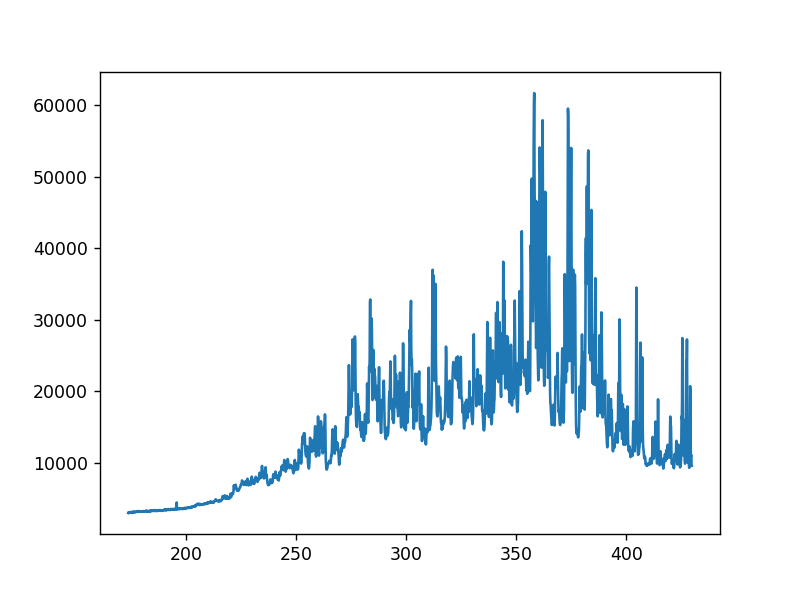

In [44]:
%matplotlib notebook
plt.plot(wl, data[:,21])

In [8]:
#for i in range(len(data[0])):
#    print(max(data[:,i]))

In [9]:
print(len(data[0]))

60


In [10]:
from glob import glob

filenames = glob('./data/*')

dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 

<class 'list'>
233


In [11]:
print(data[:,-1].shape)
print(data[-1].shape)
print(len(data))
print(len(data[0]))
print(data.shape)
print(wl.shape)

(2047,)
(60,)
2047
60
(2047, 60)
(2047, 1)


<IPython.core.display.Javascript object>


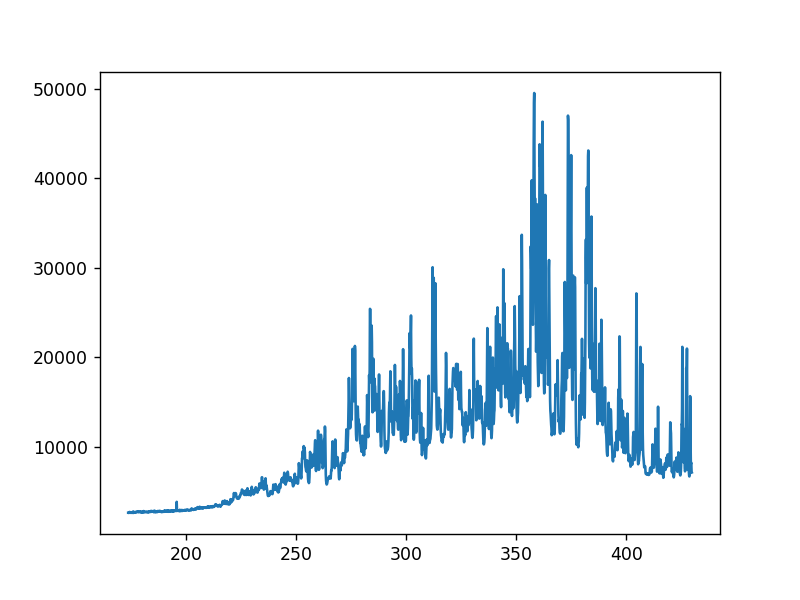

In [45]:
%matplotlib notebook
plt.plot(wl, data[:,20])
plt.show()

(2047, 1)


<IPython.core.display.Javascript object>


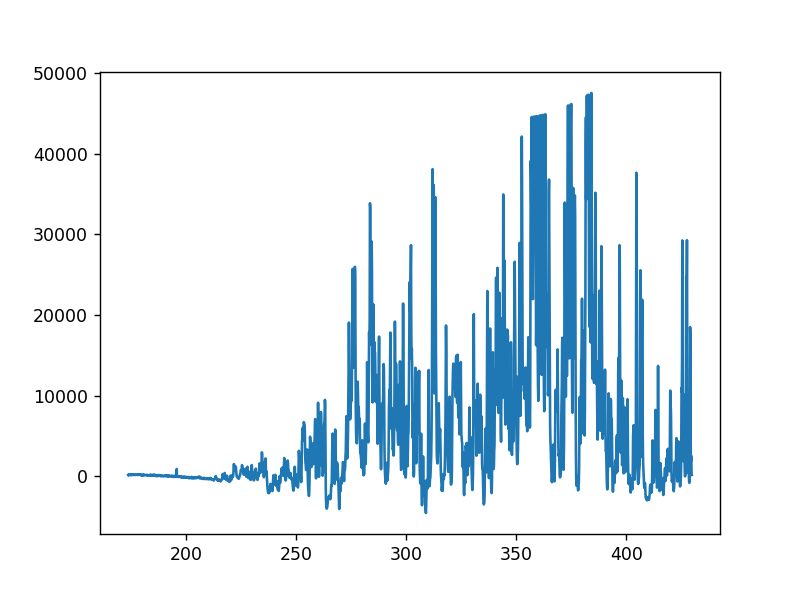

(1, 2047)
(2047, 1)


In [47]:
orig= data[:,10]

corrected, x1= drPLS(wl, orig, lam= 10e7) #lambda

print(x1.shape)

%matplotlib notebook
#plt.plot(wl, orig)
#plt.plot(wl, x1)
plt.plot(wl, corrected)
plt.show()

print(orig.reshape(1,-1).shape)
print(corrected.shape)

(2047, 1)
(2047, 1)


<IPython.core.display.Javascript object>


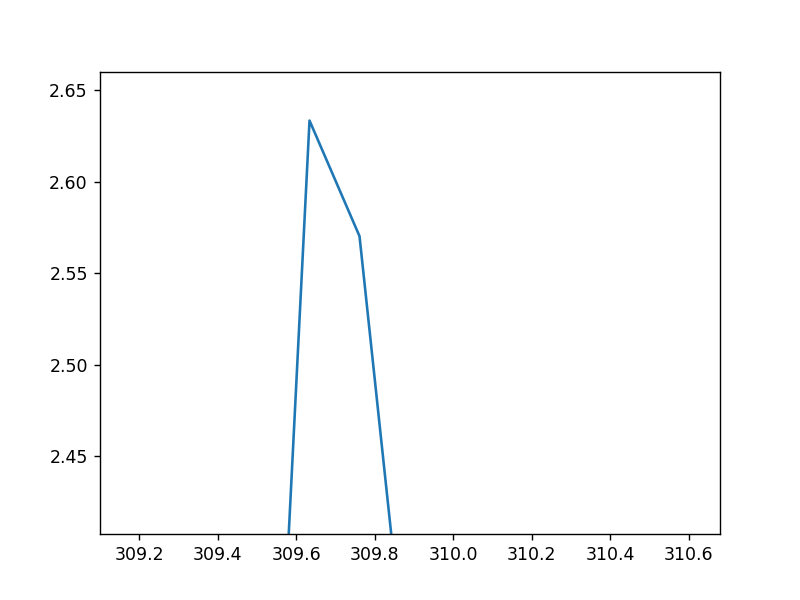

In [26]:
#a, b = msc((pd.DataFrame(corrected).dropna()).values)
#a =  orig / np.sum(orig,axis=0)
b =  corrected / np.max(corrected,axis=0)
c = normalize (corrected.reshape(1, -1))
#a = snv(orig.reshape(1,-1))
a = StandardScaler().fit_transform(corrected.reshape(-1, 1))

print(a.shape)
print(wl.shape)

%matplotlib notebook
#plt.plot(wl, corrected)
plt.plot(wl, a)
#plt.plot(wl, b)
#plt.plot(wl, c.T)
plt.show()

In [38]:
for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    wl= mat["wl"]
    data = mat["data"]
    print("data index: " + str(j))
    print("max: ",np.max(data))
    #print("data " + str(j) + " shape: ", data.shape)
    #print("wl " + str(j) + " shape: ", wl.shape)
    #print("wl[0] " + str(wl[0]) + ", wl[-1] " + str(wl[-1]))
    print("")
    

data index: 0
max:  65535

data index: 1
max:  65535

data index: 2
max:  65535

data index: 3
max:  65535

data index: 4
max:  65535

data index: 5
max:  65535

data index: 6
max:  65535

data index: 7
max:  65535

data index: 8
max:  65535

data index: 9
max:  57013

data index: 10
max:  65535

data index: 11
max:  65535

data index: 12
max:  60150

data index: 13
max:  65535

data index: 14
max:  65535

data index: 15
max:  65535

data index: 16
max:  65535

data index: 17
max:  65535

data index: 18
max:  60008

data index: 19
max:  60866

data index: 20
max:  65535

data index: 21
max:  65535

data index: 22
max:  65535

data index: 23
max:  65096

data index: 24
max:  65535

data index: 25
max:  65535

data index: 26
max:  65535

data index: 27
max:  65535

data index: 28
max:  65535

data index: 29
max:  65535

data index: 30
max:  65535

data index: 31
max:  64718

data index: 32
max:  65535

data index: 33
max:  65535

data index: 34
max:  40575

data index: 35
max:  60724

da

In [28]:
len(wl)
wl[1046]

array([309.6334])

In [17]:
data.shape

(2047, 38)

For reference line normalization on Aluminium I should use

In [63]:
## THIS IS THE COMPLETE LOOP FOR DATA MANIPULATION

#print("the wavelength used for intensity filtering is: ", wl[1046]=309.6 nm)

print(len(dfs))

tot= np.empty((0, len(wl)))
print( "tot shape: " , tot.shape)

for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    if(len(data) != len(wl)):
        data = data[:-1,:]
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))
    
    for i in (range(len(data[0])) ):
        
        orig= data[:,i]
        #corrected= data[:,i]
        
        #if ((max(orig)) < 65500):
        #if ((max(orig)) < 65500) and ((max(orig)) > 25500):
            
        corrected, x1= drPLS(wl, orig, lam= 10e7)
        #print(corrected.shape)

        #if corrected[1046] > 5500:
        #if corrected[1046] > 5500 and (max(orig)) < 65000:
        if max(corrected) > 10000 and (max(orig)) < 65000:
            count += 1
            
            #corrected = normalize (corrected.reshape(1, -1))
            #corrected=  snv(corrected.reshape(-1, 1))
            #corrected =  corrected / np.sum(corrected,axis=0)
            corrected =  corrected / np.max(corrected,axis=0)
            #corrected = corrected/corrected[1046]
            
            tmp = np.append(tmp, corrected.reshape(1, -1), axis=0)

            #print("a:", a.shape)
            #print("tmp:", tmp.shape)

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape, "\n")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

233
tot shape:  (0, 2047)
data index: 0
data 0 shape:  (2047, 60)
good spectra:  36
tmp shape:  (36, 2047)
avg array shape:  (1, 2047) 

data index: 1
data 1 shape:  (2047, 54)
good spectra:  28
tmp shape:  (28, 2047)
avg array shape:  (1, 2047) 

data index: 2
data 2 shape:  (2047, 53)
good spectra:  14
tmp shape:  (14, 2047)
avg array shape:  (1, 2047) 

data index: 3
data 3 shape:  (2047, 44)
good spectra:  15
tmp shape:  (15, 2047)
avg array shape:  (1, 2047) 

data index: 4
data 4 shape:  (2047, 48)
good spectra:  34
tmp shape:  (34, 2047)
avg array shape:  (1, 2047) 

data index: 5
data 5 shape:  (2047, 50)
good spectra:  26
tmp shape:  (26, 2047)
avg array shape:  (1, 2047) 

data index: 6
data 6 shape:  (2047, 37)
good spectra:  31
tmp shape:  (31, 2047)
avg array shape:  (1, 2047) 

data index: 7
data 7 shape:  (2047, 46)
good spectra:  26
tmp shape:  (26, 2047)
avg array shape:  (1, 2047) 

data index: 8
data 8 shape:  (2047, 53)
good spectra:  30
tmp shape:  (30, 2047)
avg a

good spectra:  25
tmp shape:  (25, 2047)
avg array shape:  (1, 2047) 

data index: 74
data 74 shape:  (2047, 42)
good spectra:  31
tmp shape:  (31, 2047)
avg array shape:  (1, 2047) 

data index: 75
data 75 shape:  (2047, 40)
good spectra:  22
tmp shape:  (22, 2047)
avg array shape:  (1, 2047) 

data index: 76
data 76 shape:  (2047, 33)
good spectra:  26
tmp shape:  (26, 2047)
avg array shape:  (1, 2047) 

data index: 77
data 77 shape:  (2047, 40)
good spectra:  28
tmp shape:  (28, 2047)
avg array shape:  (1, 2047) 

data index: 78
data 78 shape:  (2047, 34)
good spectra:  32
tmp shape:  (32, 2047)
avg array shape:  (1, 2047) 

data index: 79
data 79 shape:  (2047, 52)
good spectra:  35
tmp shape:  (35, 2047)
avg array shape:  (1, 2047) 

data index: 80
data 80 shape:  (2047, 58)
good spectra:  22
tmp shape:  (22, 2047)
avg array shape:  (1, 2047) 

data index: 81
data 81 shape:  (2047, 54)
good spectra:  33
tmp shape:  (33, 2047)
avg array shape:  (1, 2047) 

data index: 82
data 82 sh

good spectra:  16
tmp shape:  (16, 2047)
avg array shape:  (1, 2047) 

data index: 146
data 146 shape:  (2047, 41)
good spectra:  33
tmp shape:  (33, 2047)
avg array shape:  (1, 2047) 

data index: 147
data 147 shape:  (2047, 50)
good spectra:  19
tmp shape:  (19, 2047)
avg array shape:  (1, 2047) 

data index: 148
data 148 shape:  (2047, 36)
good spectra:  20
tmp shape:  (20, 2047)
avg array shape:  (1, 2047) 

data index: 149
data 149 shape:  (2047, 61)
good spectra:  14
tmp shape:  (14, 2047)
avg array shape:  (1, 2047) 

data index: 150
data 150 shape:  (2047, 61)
good spectra:  52
tmp shape:  (52, 2047)
avg array shape:  (1, 2047) 

data index: 151
data 151 shape:  (2047, 34)
good spectra:  21
tmp shape:  (21, 2047)
avg array shape:  (1, 2047) 

data index: 152
data 152 shape:  (2047, 89)
good spectra:  16
tmp shape:  (16, 2047)
avg array shape:  (1, 2047) 

data index: 153
data 153 shape:  (2047, 32)
good spectra:  22
tmp shape:  (22, 2047)
avg array shape:  (1, 2047) 

data inde

good spectra:  46
tmp shape:  (46, 2047)
avg array shape:  (1, 2047) 

data index: 218
data 218 shape:  (2047, 64)
good spectra:  33
tmp shape:  (33, 2047)
avg array shape:  (1, 2047) 

data index: 219
data 219 shape:  (2047, 53)
good spectra:  15
tmp shape:  (15, 2047)
avg array shape:  (1, 2047) 

data index: 220
data 220 shape:  (2047, 58)
good spectra:  28
tmp shape:  (28, 2047)
avg array shape:  (1, 2047) 

data index: 221
data 221 shape:  (2047, 51)
good spectra:  16
tmp shape:  (16, 2047)
avg array shape:  (1, 2047) 

data index: 222
data 222 shape:  (2047, 62)
good spectra:  10
tmp shape:  (10, 2047)
avg array shape:  (1, 2047) 

data index: 223
data 223 shape:  (2047, 63)
good spectra:  15
tmp shape:  (15, 2047)
avg array shape:  (1, 2047) 

data index: 224
data 224 shape:  (2047, 61)
good spectra:  24
tmp shape:  (24, 2047)
avg array shape:  (1, 2047) 

data index: 225
data 225 shape:  (2047, 29)
good spectra:  3
tmp shape:  (3, 2047)
avg array shape:  (1, 2047) 

data index:

<IPython.core.display.Javascript object>


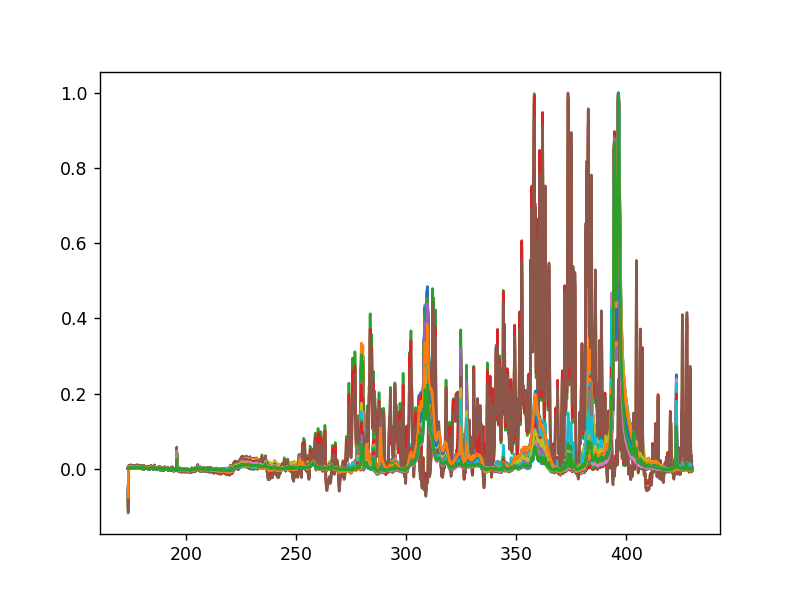

In [64]:
%matplotlib notebook
#%matplotlib inline

for i in range(len(tot)):
    #print(i)
    plt.plot(wl, tot[i])
    plt.show()

In [65]:
print(wl.shape)
wl1= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
print(a.shape)
print(a)

np.savetxt("ausom_max.csv", a, delimiter=",", fmt='%f')

(2047, 1)
(233, 2047)
(234, 2047)
[[ 1.73738600e+02  1.73868800e+02  1.73999000e+02 ...  4.29601300e+02
   4.29711600e+02  4.29821800e+02]
 [ 1.10781522e-03  3.31613082e-03  1.22318522e-04 ... -4.22552299e-03
  -4.73651958e-03 -3.94833953e-03]
 [ 7.64730704e-04  2.59357327e-03  3.82014088e-04 ... -2.97496633e-03
  -3.49239037e-03 -2.67569507e-03]
 ...
 [-6.68774198e-02  3.78892797e-03  2.25184005e-03 ... -2.58441673e-03
  -4.09539084e-03 -2.29517285e-03]
 [-7.56691698e-02  4.42596862e-03  2.39295987e-03 ... -3.85003497e-03
  -5.60958858e-03 -4.11086639e-03]
 [ 9.33538481e-04  2.19756981e-03  5.09969742e-05 ... -2.97098081e-03
  -4.43044559e-03 -2.46691036e-03]]


### Wavelet transform

In [18]:
import pywt
import pywt.data
#print(pywt.families(short=False))
print(pywt.families(short=True), "\n")
print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'] 

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sy

<IPython.core.display.Javascript object>


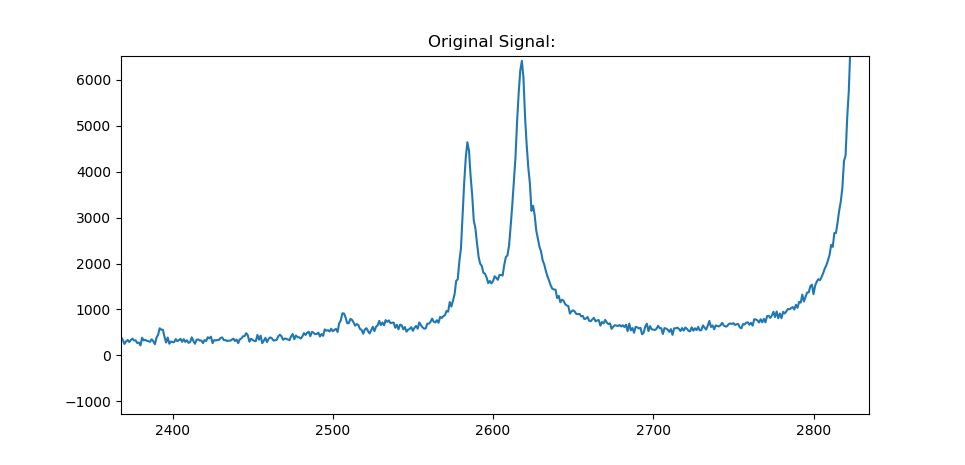

(3648,)


<IPython.core.display.Javascript object>


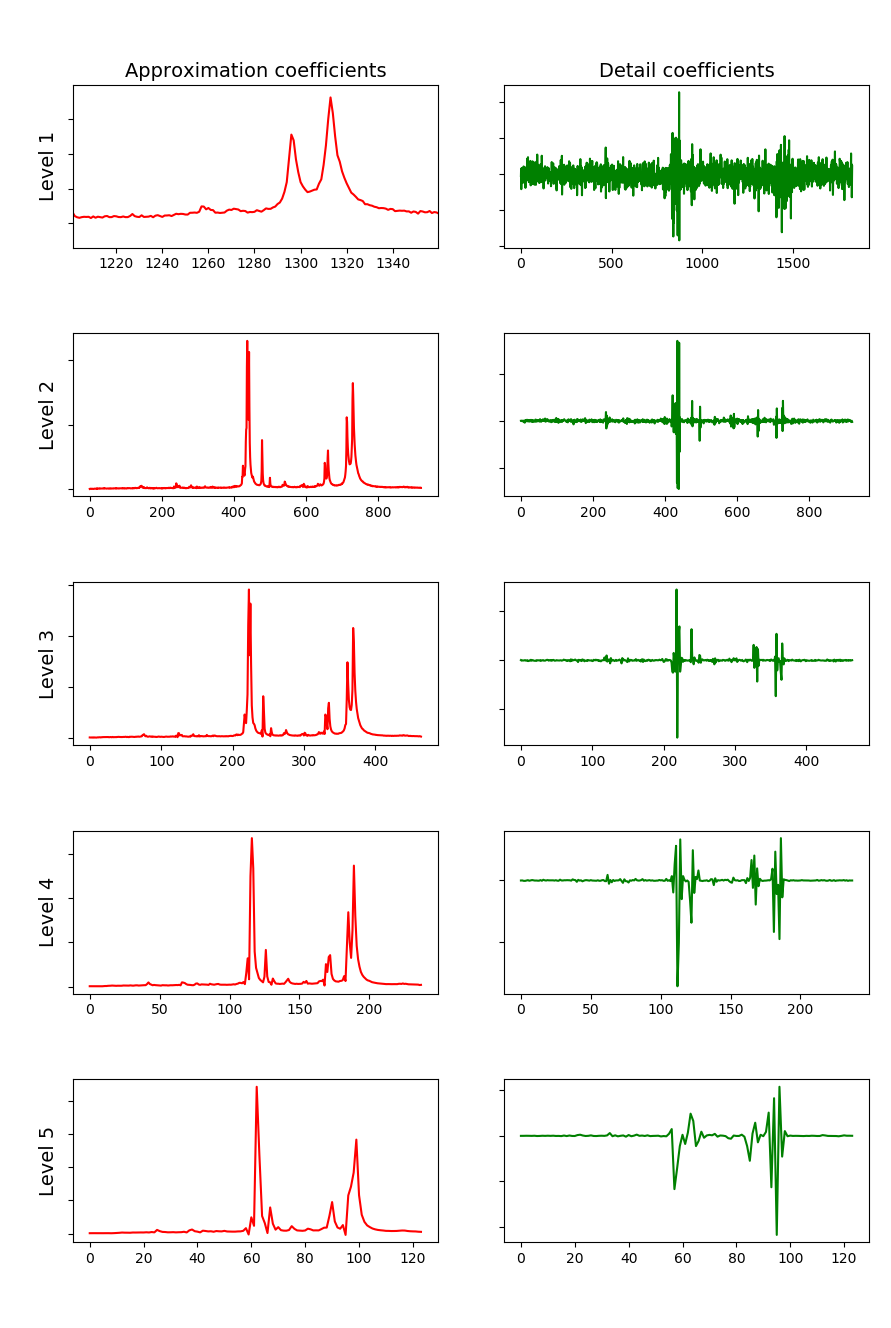

In [42]:
%matplotlib notebook


fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal: ")
ax.plot(data[:,10])
plt.show()
    
data1 = data[:,10]
print(data1.shape)
waveletname = 'db6'
 
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))
for ii in range(5):
    (data1, coeff_d) = pywt.dwt(data1, waveletname)
    axarr[ii, 0].plot(data1, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
plt.tight_layout()
plt.show()

In [67]:
a, b =pywt.swt(data1, waveletname, level=2) 

print(type(a))
print(len(a))
print(a[1].shape)
print(type(a[0]))
print(b[1].shape)
print(type(b[0]))

print(type(a))
print(len(a))
print(type(a[1]))
print(type(a[0]))
print(a[0][0].shape)
print(a[0][0])

#plt.plot(wl, a[0][0])

<class 'tuple'>
2
(124,)
<class 'numpy.ndarray'>
(124,)
<class 'numpy.ndarray'>
<class 'tuple'>
2
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
()
3371.4281153625648


- The DWT return two sets of coefficients; the approximation coefficients and detail coefficients.
- The approximation coefficients represent the output of the low pass filter (averaging filter) of the DWT.
- The detail coefficients represent the output of the high pass filter (difference filter) of the DWT.
- By applying the DWT again on the approximation coefficients of the previous DWT, we get the wavelet transform of the next level.
- At each next level, the original signal is also sampled down by a factor of 2.

<IPython.core.display.Javascript object>


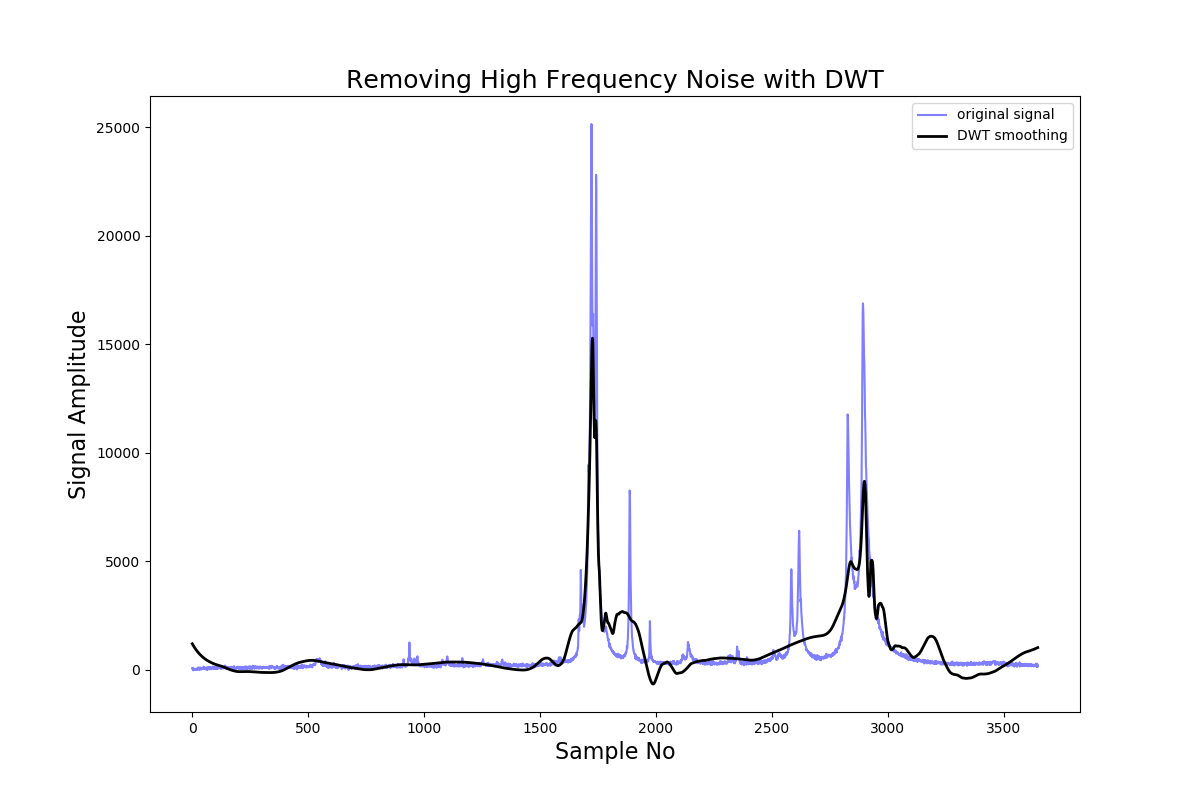

In [30]:
#Is this even useful???

signal = data[:,10]

def lowpassfilter(signal, thresh = 0.63, wavelet="db6"):
#def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="sp1" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="sp1" )
    return reconstructed_signal
 
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
rec = lowpassfilter(signal, 0.4)
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

# Normalization

In [16]:
data[0,:]

array([4834., 4823., 4700., ..., 4533., 4572., 4599.])

In [17]:
a= normalize(data[0,:].reshape(1, -1))
a.shape

(1, 1446)

In [18]:
print(wl.shape)
print(a.shape)

(1446,)
(1, 1446)


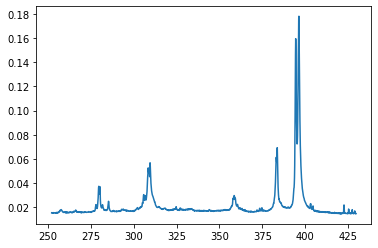

In [21]:
%matplotlib inline
plt.plot(wl, a.T)
plt.show()

(1446,)
(100, 1446)


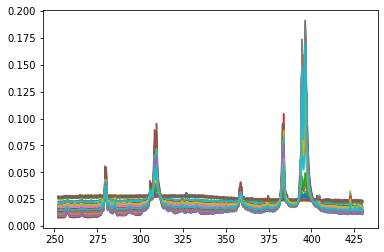

In [23]:
tmp=normalize(data)
print(wl.shape)
print(tmp.shape)


%matplotlib inline
for i in range(len(tmp)):
    plt.plot(wl, tmp[i,:])
    #plt.show()

In [24]:
print(wl.shape)
print(len(wl))

(1446,)
1446


In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)):
    data = dfs[j].values
    data = data[1:,:]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    
    for i in (range(len(data)) ):
    
        z_i = baseline_als(data[i,:], lam, p, niter=10)

        a = data[i,:] - z_i


        if (max(a)) > 25000:

            #a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl, a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape) 

In [ ]:
for i in range(len(tot)):
    plt.plot(wl, tot[i])
    #plt.show()

In [ ]:
print(tot.shape)
print(wl.shape)

In [ ]:
print(wl.shape)
wl= wl.reshape(1,-1)
print(tot.shape)

a= np.append(wl, tot, axis=0)
print(a.shape)
print(a)

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')

In [ ]:
X_std = StandardScaler().fit_transform(data)
print(X_std.shape)
X_std

In [ ]:
data_sum= data / np.sum(data,axis=0)
data_sum

In [ ]:
for i in (range(len(X_std[0]))):
    
    plt.plot(wl, X_std[:,i] )
    plt.show()
    

In [ ]:
print(max(data[:,8]))
print(max(data[:,11]))
max(data[:,1])

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    a = data[:,i] - z_i
    
    #a=  a / np.sum(a,axis=0)
    #a=  a / np.max(a,axis=0)


    count += 1
    #print(i)
    plt.plot(wl, a)
    #plt.show()
print("good spectra: ", count)

In [ ]:
count = 0
for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[600:1730,i], lam, p, niter=10)
    
    a = data[600:1730,i] - z_i
    
    
    if (max(a)) > 25000:
        
        a =  a / np.sum(a,axis=0)
        #a = StandardScaler().fit_transform(a.reshape(-1, 1))
        #a= normalize(a.reshape(-1, 1))
        
        count += 1
        #print(i)
        plt.plot(wl[600:1730], a)
        plt.show()
        #plt.savefig('./graph.png')
print("good spectra: ", count)

In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    
    z_i = baseline_als(data[:,i], lam, p, niter=10)
    
    if ((max(data[:,i]-z_i)) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        tmp = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.max(tmp, axis=0)
#avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)




In [ ]:
count=0

#result_array = np.empty_like(wl)
tmp = np.empty((0, len(wl)))

for i in (range(len(data[0])) ):
    if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        count += 1
        #print(i)
        plt.plot(wl, data[:,i])
        #plt.show()
        result_array = np.append(tmp, [data[:,i]], axis=0)
        
        
print("good spectra: ", count)
print(tmp.shape)

avg_arr= np.mean(tmp, axis=0)
print(avg_arr.shape)



In [ ]:

plt.plot(wl, avg_arr)
plt.show()

In [ ]:

good = np.empty([len(wl)])

good1 = np.empty_like(wl)

print(good.shape)
print(good1.shape)

In [ ]:
print(result_array.shape)
print(result_array)
a=np.mean(result_array, axis=0)
print(a.shape)

In [ ]:
"""from glob import glob

#filenames = glob('./ref/*')
filenames = glob('./ref_1/*')


dfs = [scipy.io.loadmat(f) for f in filenames]
print(type(dfs)) #dfs is a list of mat files 
print(len(dfs)) #dfs is a list of mat files 
"""

In [ ]:
tot= np.empty((0, len(wl)))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl)))

    for i in (range(len(data[0])) ):
        
        
    
        if ((max(data[:,i])) > 10000) and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [data[:,i]], axis=0)


    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    #avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

WITH BASELINE CORRECTION

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
    
        z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

        a = data[600:1730,i] - z_i


        if (max(a)) > 25000:

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            plt.plot(wl[600:1730], a)
            plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
tot= np.empty((0, len(wl[600:1730])))


for j in range(0, len(dfs)): #loop over all .mat files
    mat = dfs[j]
    data = mat["data"]
    print("data index: " + str(j))
    print("data " + str(j) + " shape: ", data.shape)
    
    count=0

    #result_array = np.empty_like(wl)
    
    tmp = np.empty((0, len(wl[600:1730])))

    
    for i in (range(len(data[0])) ):
        if (max(data[:,i])) > 25000:
            
            
            z_i = baseline_als(data[600:1730,i], lam, p, niter=10)

            a = data[600:1730,i] - z_i


        

            a =  a / np.sum(a,axis=0)
            #a = StandardScaler().fit_transform(a.reshape(-1, 1))
            #a= normalize(a.reshape(-1, 1))

            count += 1
            #print(i)
            #plt.plot(wl[600:1730], a)
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    
    """
    for i in (range(len(data[0])) ):
        
        z_i = baseline_als(data[:,i], lam, p, niter=10)

        a = data[:,i] - z_i    
        
    
        if ((max(a)) > 2000): # and ((max(data[:,i])) < 65500):
        #if ((max(data[:,i])) > 10000):
            count += 1
            #print(i)
            #plt.plot(wl, data[:,i])
            #plt.show()
            tmp = np.append(tmp, [a], axis=0)
    """

    print("good spectra: ", count)
    print("tmp shape: ", tmp.shape)

    avg_arr= np.mean(tmp, axis=0).reshape((1, -1))
    #avg_arr= np.max(tmp, axis=0).reshape((1, -1))
    print("avg array shape: " , avg_arr.shape)
    print("")
    
    
    tot = np.append(tot, avg_arr, axis=0)

print(tot.shape)  

In [ ]:
for i in range(len(tot)):
    plt.plot(wl[600:1730], tot[i])
    #plt.show()

In [ ]:
ded #np.savetxt("avg_intesities.csv", tot, delimiter=",", fmt='%f')

In [ ]:
print(wl.shape)
wl1= wl[600:1730].reshape(1,-1)
print(tot.shape)

a= np.append(wl1, tot, axis=0)
a.shape
a

In [ ]:
#np.savetxt("avg_intesities_baseline_1.csv", a, delimiter=",", fmt='%f')